Suppose we have a differential equation: 
    
$$
\frac{dy}{dt} = f(y(t), t)
$$

While in some cases, there are analytic solutions to differential equations of this form, in general, we will not be able to write down a solution. In cases like this, numerical integration is important. Here, we will implent the Runge-Kutta 4th order integration method (also known as RK4). 

Let's consider an example differential equation that does have an analytic solution that we can compare against our numerical integration. 

$$
\frac{dy}{dt} = y(t)
$$

Let's imagine that at time t = 0, y = 1. 

In [1]:
#start by importing packages
import numpy as np
import matplotlib.pyplot as plt

In [2]:
t = np.arange(0, 5, 0.1) # create some time array to loop over
yexact = np.exp(t) # this is the analytic solution to the differential equation. We'll compare this against our 
#numerical approximations. 
def dydt(y, t):
    return y

The simplest way to integrate this equation is called "First order Runge-Kutta", and is also known as "Euler's method". Basically, you take your initial position (at some starting time $t = t_0$), use that to calculate the slope $dy/dt$ at that time. Then, to calculate the $y$ value of a point at a slightly different $t = t_1$, you can calculate:
$$y(t=t_1) \approx y(t = t_0) + (t_1 - t_0) \frac{dy}{dt}.$$
This is just using the first-order Taylor approximation to the function to calculate values at a slightly different time. You can then repeat this process many times to get an approximation of the behavior of the function: 

In [3]:
y = np.zeros(len(t)) # initialize an array with null values everywhere
y[0] = 1 #plug in the initial position

for i in range(len(t)-1): #Loop through all time stamps
    y[i+1] = y[i] + (t[i+1] - t[i])*dydt(y[i], t[i])  #and at each one, calcuate this y value, given the previous one
    

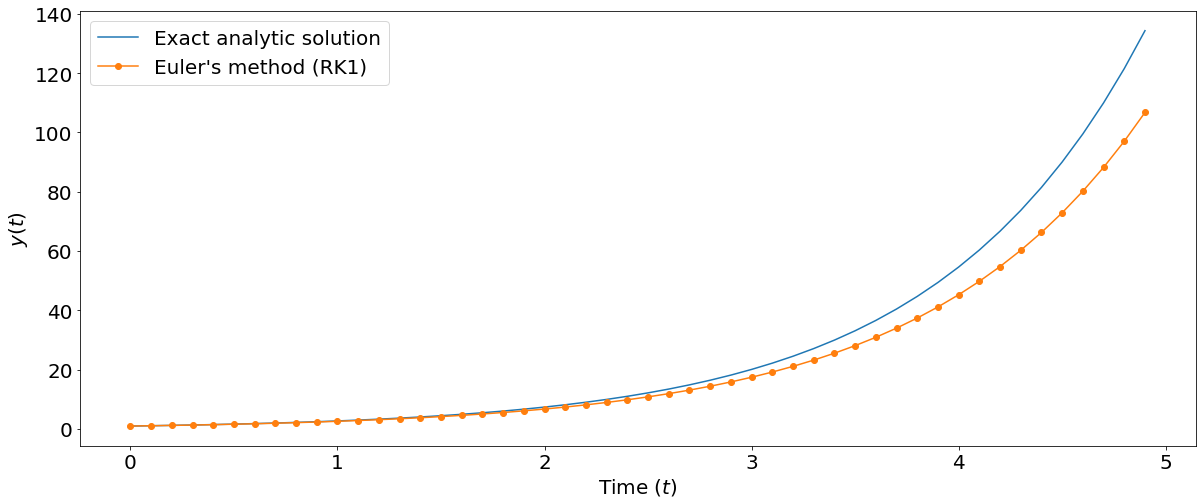

In [4]:
plt.rc('xtick', labelsize=20) 
plt.rc('ytick', labelsize=20) 

plt.figure(figsize = (20, 8))
plt.plot(t, yexact, label = "Exact analytic solution")

plt.plot(t, y, 'o-',label="Euler's method (RK1)")
plt.legend(fontsize = 20)
plt.xlabel('Time ($t$)', fontsize = 20)
plt.ylabel('$y(t)$', fontsize = 20);

We find that the first-order solution matches fairly well at early times, but at later times, the approximation becomes worse and worse. One way to solve this problem is to use smaller steps:

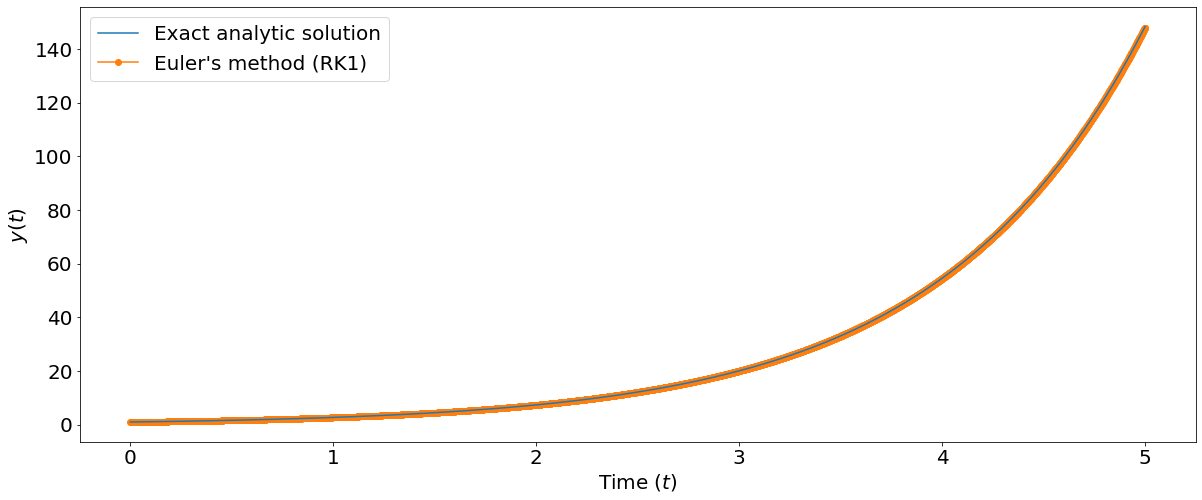

In [5]:
tfine = np.arange(0, 5, 0.001) # create some time array to loop over, with much finer spacing
yexactfine = np.exp(tfine) # this is the analytic solution to the differential equation. We'll compare this against our 
yfine = np.zeros(len(tfine)) # initialize an array with null values everywhere
yfine[0] = 1 #plug in the initial position

for i in range(len(tfine)-1): #Loop through all time stamps
    yfine[i+1] = yfine[i] + (tfine[i+1] - tfine[i])*dydt(yfine[i], tfine[i])  #and at each one, calcuate this y value, given the previous one

    
plt.figure(figsize = (20, 8))
plt.plot(tfine, yexactfine, label = "Exact analytic solution", zorder=5)

plt.plot(tfine, yfine, 'o-',label="Euler's method (RK1)")
plt.legend(fontsize = 20)
plt.xlabel('Time ($t$)', fontsize = 20)
plt.ylabel('$y(t)$', fontsize = 20);    

However, this is considerably more computationally expensive (100x worse). There is a better way to improve the results, which is to estimate the slope of the function more accurately. 

In the first-order case, we just calculated the slope at $y(t = t_0)$ and applied that slope correction over the entire interval between $t_0 and t_1$. What if, instead, we used the slope at the center of that interval ($(t_0+t_1)/2$)? That would be better, but in order to calculate that slope, we need to know the value of $y(t)$ at that intermediate time.  

To estimate this, let's use the first-order estimate of the function $y$ at time $t=(t_0+t_1)/2$ to calculate the derivative. Then, we can use that intermediate derivative to calculate the next time step. 

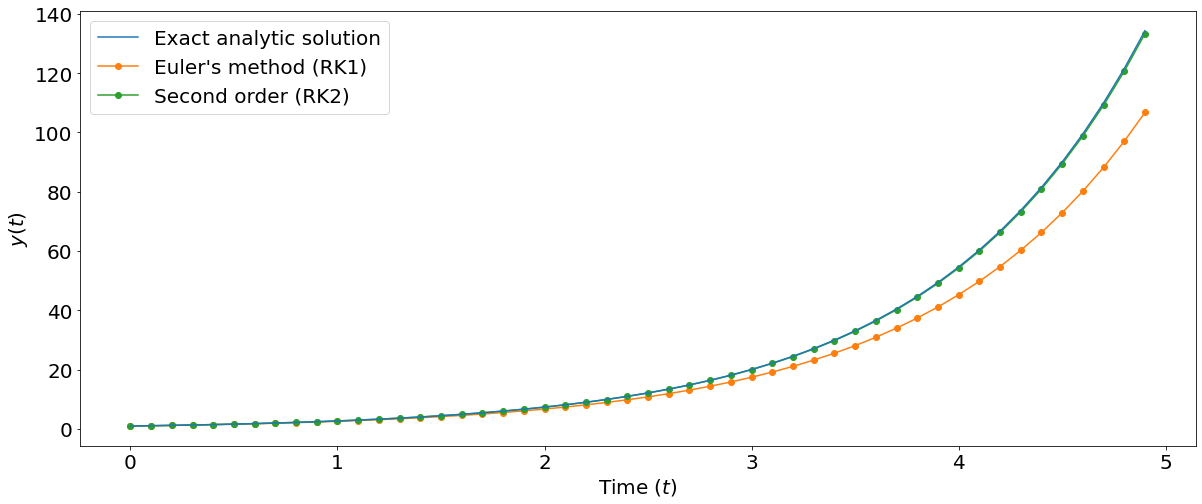

In [6]:
t = np.arange(0, 5, 0.1) # create some time array to loop over, back to our original spacing. 
y2 = np.zeros(len(t)) # initialize an array with null values everywhere
y2[0] = 1 #plug in the initial position

for i in range(len(t)-1): #Loop through all time stamps
    yintermediate = y2[i] + (t[i+1] - t[i])/2*dydt(y2[i], t[i])
    y2[i+1] = y2[i] + (t[i+1] - t[i])*dydt(yintermediate, (t[i+1] + t[i])/2)  #and at each one, calcuate this y value, given the previous one

    
plt.figure(figsize = (20, 8))
plt.plot(t, yexact, label = "Exact analytic solution", zorder=5)

plt.plot(t, y, 'o-',label="Euler's method (RK1)")
plt.plot(t, y2, 'o-',label="Second order (RK2)")
plt.legend(fontsize = 20)
plt.xlabel('Time ($t$)', fontsize = 20)
plt.ylabel('$y(t)$', fontsize = 20);    

That's a big improvement! With only one extra calculation per timestep, we have gotten a much better estimate of the true solution. However, there are still some errors. Instead of plotting the function itself, let's plot the fractional errors for the second order scheme:

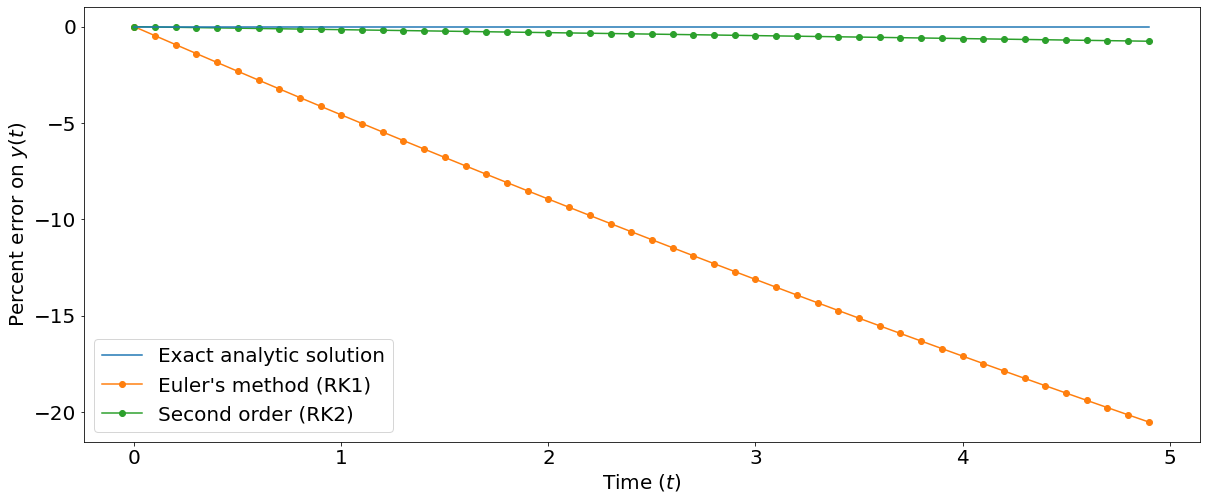

In [7]:
plt.figure(figsize = (20, 8))
plt.plot(t, yexact-yexact, label = "Exact analytic solution", zorder=5)

plt.plot(t, 100*(y-yexact)/yexact, 'o-',label="Euler's method (RK1)")
plt.plot(t, 100*(y2-yexact)/yexact, 'o-',label="Second order (RK2)")
plt.legend(fontsize = 20)
plt.xlabel('Time ($t$)', fontsize = 20)
plt.ylabel('Percent error on $y(t)$', fontsize = 20);    

The second order approximation is still off by about a percent after this small number of steps. We can do better still by getting a more precise estimate of the average slope over the entire interval. To do this, we can take four different estimates of the slope across the time step. These estimates include: 

- The slope at the beginning of the interval, as we calcualted in the first-order case. Call this $k_1$. 
- The slope in the middle of the interval, as we calculated in the second order case. Call this $k_2$. 
- The slope in the middle of the interval, but calculated assuming the $k_2$ slope we calculated. Call this $k_3$. 
- The slope at the end of the interval, calculated using the $k_3$ slope. Call this $k_4$. 

Then, we can calculate a weighted average $\bar k$ of these four slopes. A good weighting scheme is: 

$$
\bar k = \frac{k_1 + 2k_2 + 2k_3 + k_4}{6}
$$

Finally, calculate the next step assuming this average slope: 

$$y(t=t_1) \approx y(t = t_0) + (t_1 - t_0) \bar{k}.$$

Let's implement this: 

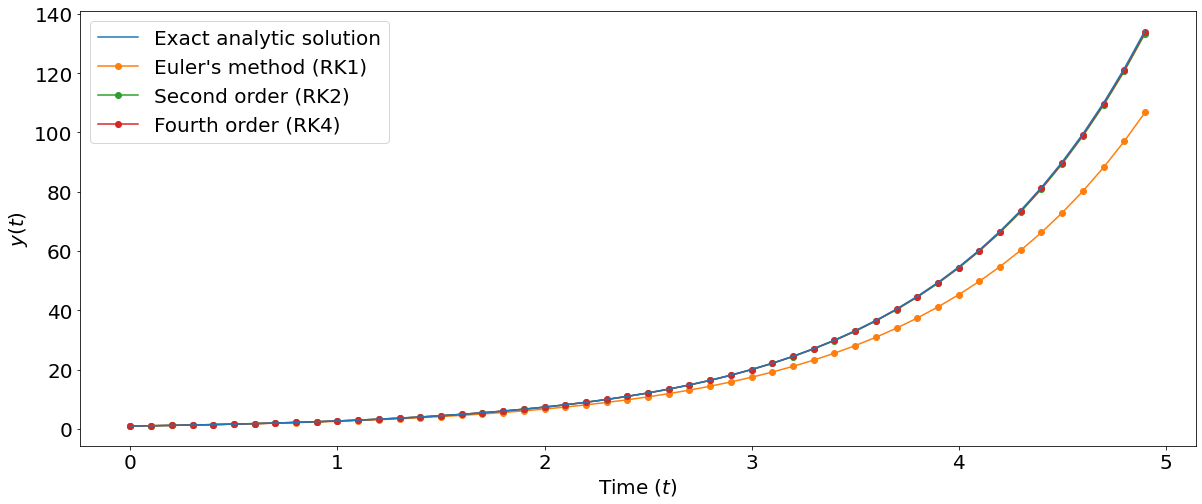

In [8]:
t = np.arange(0, 5, 0.1) # create some time array to loop over, back to our original spacing. 
y4 = np.zeros(len(t)) # initialize an array with null values everywhere
y4[0] = 1 #plug in the initial position

for i in range(len(t)-1): #Loop through all time stamps
    k1 = dydt(y4[i], t[i])
    yintermediate = y4[i] + (t[i+1] - t[i])/2*k1
    k2 = dydt(yintermediate, (t[i+1] + t[i])/2)
    yintermediate2 = y4[i] + (t[i+1] - t[i])/2*k2
    k3 = dydt(yintermediate2, (t[i+1] + t[i])/2)
    yend = y4[i] + (t[i+1] - t[i])*k3
    k4 = dydt(yend, t[i+1])
    kbar = (k1+2*k2 + 2*k2 + k4)/6
    y4[i+1] = y4[i] + (t[i+1] - t[i])*kbar  #and at each one, calcuate this y value, given the previous one

    
plt.figure(figsize = (20, 8))
plt.plot(t, yexact, label = "Exact analytic solution", zorder=5)

plt.plot(t, y, 'o-',label="Euler's method (RK1)")
plt.plot(t, y2, 'o-',label="Second order (RK2)")
plt.plot(t, y4, 'o-',label="Fourth order (RK4)")
plt.legend(fontsize = 20)
plt.xlabel('Time ($t$)', fontsize = 20)
plt.ylabel('$y(t)$', fontsize = 20);    

Showing the percent errors: 


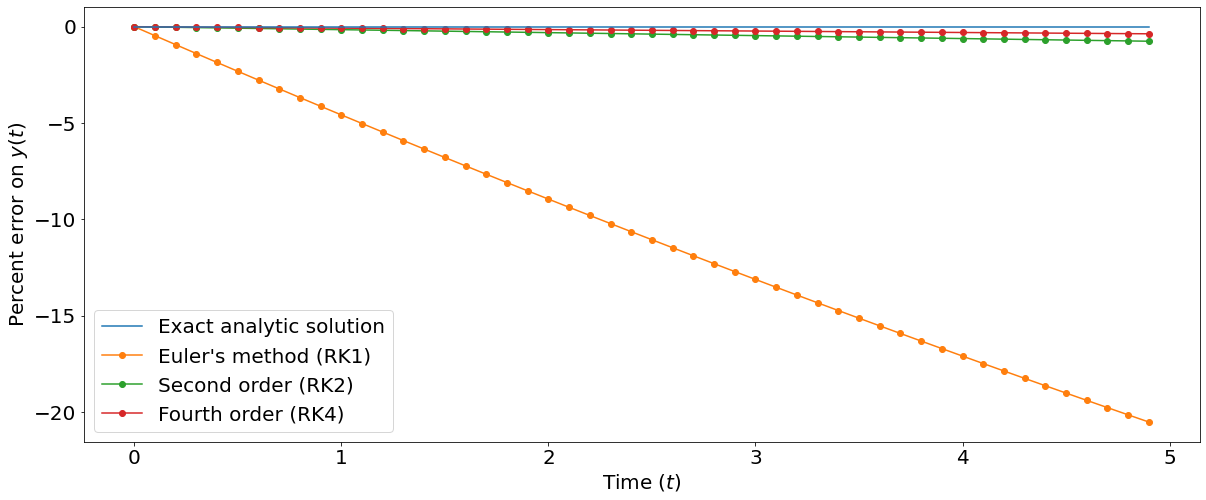

In [9]:
plt.figure(figsize = (20, 8))
plt.plot(t, yexact-yexact, label = "Exact analytic solution", zorder=5)

plt.plot(t, 100*(y-yexact)/yexact, 'o-',label="Euler's method (RK1)")
plt.plot(t, 100*(y2-yexact)/yexact, 'o-',label="Second order (RK2)")
plt.plot(t, 100*(y4-yexact)/yexact, 'o-',label="Fourth order (RK4)")

plt.legend(fontsize = 20)
plt.xlabel('Time ($t$)', fontsize = 20)
plt.ylabel('Percent error on $y(t)$', fontsize = 20);    

Fourth order Runge-Kutta integration is a commonly used algorithm. It is possible to go to higher orders, but RK4 is a good balance between convenience and accuracy. 